# Lasso regression with cross validation
The following code tests Lasso regression on franke function. I have not (yet) implemented my own Lasso regression function, but instead I use the Lasso method provided by sklearn. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Lasso as Lasso_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

poly = 16
k_folds = 7
lambda_lasso = 0.001
MSE_skl_list = []

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3
 
x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) #number of data points
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for k in tqdm.tqdm(range(k_folds)): 
    MSE = []
    
    # extract folds
    xyz_test = xyz_folds[k]
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold
    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(
            degree=poly_deg), Lasso_skl(alpha=lambda_lasso, fit_intercept=True))
        #sklearn:
        z_pred = model_skl.fit(xy_train, z_train.reshape(-1, 1)).predict(xy_test)
        MSE.append(np.mean((z_pred.ravel() - z_test.ravel())**2)) 
        
    MSE_skl_list.append(MSE)
    
MSE_skl_list = np.array(MSE_skl_list)

#study average values
test_skl_avrg = np.mean(MSE_skl_list, axis=0)

100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


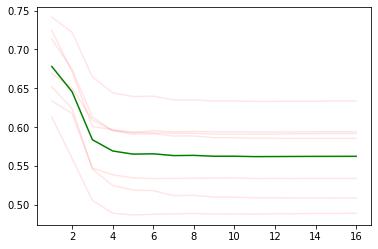

In [2]:
for i in range(len(MSE_skl_list)):
    plt.plot(range(1, len(MSE)+1), MSE_skl_list[i], 'r', alpha=0.1)
plt.plot(range(1, len(MSE)+1), test_skl_avrg, 'g')


#plt.ylim(0.95, 1.1)
plt.show()

## Lasso regression with bootstrap
In this example I try to estimate confidence intervals for beta values using bootstrap resampeling. I also study the spread in beta values and how the Lasso can shrink some (or almost all) betavalues to exact zero. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from franke_function import FrankeFunction as Fr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tqdm # progressbar

#sk-learn linear regression
from sklearn.linear_model import Lasso as Lasso_skl
from sklearn.linear_model import Ridge as Ridge_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

x = np.linspace(0, 1, 50) 
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
z = Fr(x, y) + noise*0.3

x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 
xy_train, xy_test, z_train, z_test = train_test_split(np.hstack([x_cent, y_cent]), z_cent, test_size=0.5)

poly = 18
n_bootstraps = 100
lambda_lasso = 0.0001
betas_list = []
iterations = 100000
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        
        # store all values for averaging
    betas_list.append(beta_poly) 

betas_list = np.array(betas_list, dtype=object)
l1_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l1_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta


lambda_lasso = 0.01
betas_list = []
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        
        # store all values for averaging
    betas_list.append(beta_poly) 

betas_list = np.array(betas_list, dtype=object)
l2_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l2_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta

lambda_lasso = 0.1
betas_list = []
for n in tqdm.tqdm(range(n_bootstraps)): 
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    
    #Bootstrap: Draw n samples from training set
    n = z_train.size 
    samples_nr = np.random.randint(0,n,n)
    xy_samp = xy_train[samples_nr, :] # sampling train data
    z_samp = z_train[samples_nr, :]
            
    # polynomial fit to bootstrap samples
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))

        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        
        # store all values for averaging
    betas_list.append(beta_poly) 

betas_list = np.array(betas_list, dtype=object)
l3_mean_betas_bootstrap = np.mean(betas_list, axis=0) 
l3_var_betas_bootstrap = np.var(betas_list, axis=0) #monte carlo estimate of variance in beta

100%|██████████| 100/100 [00:04<00:00, 22.91it/s]


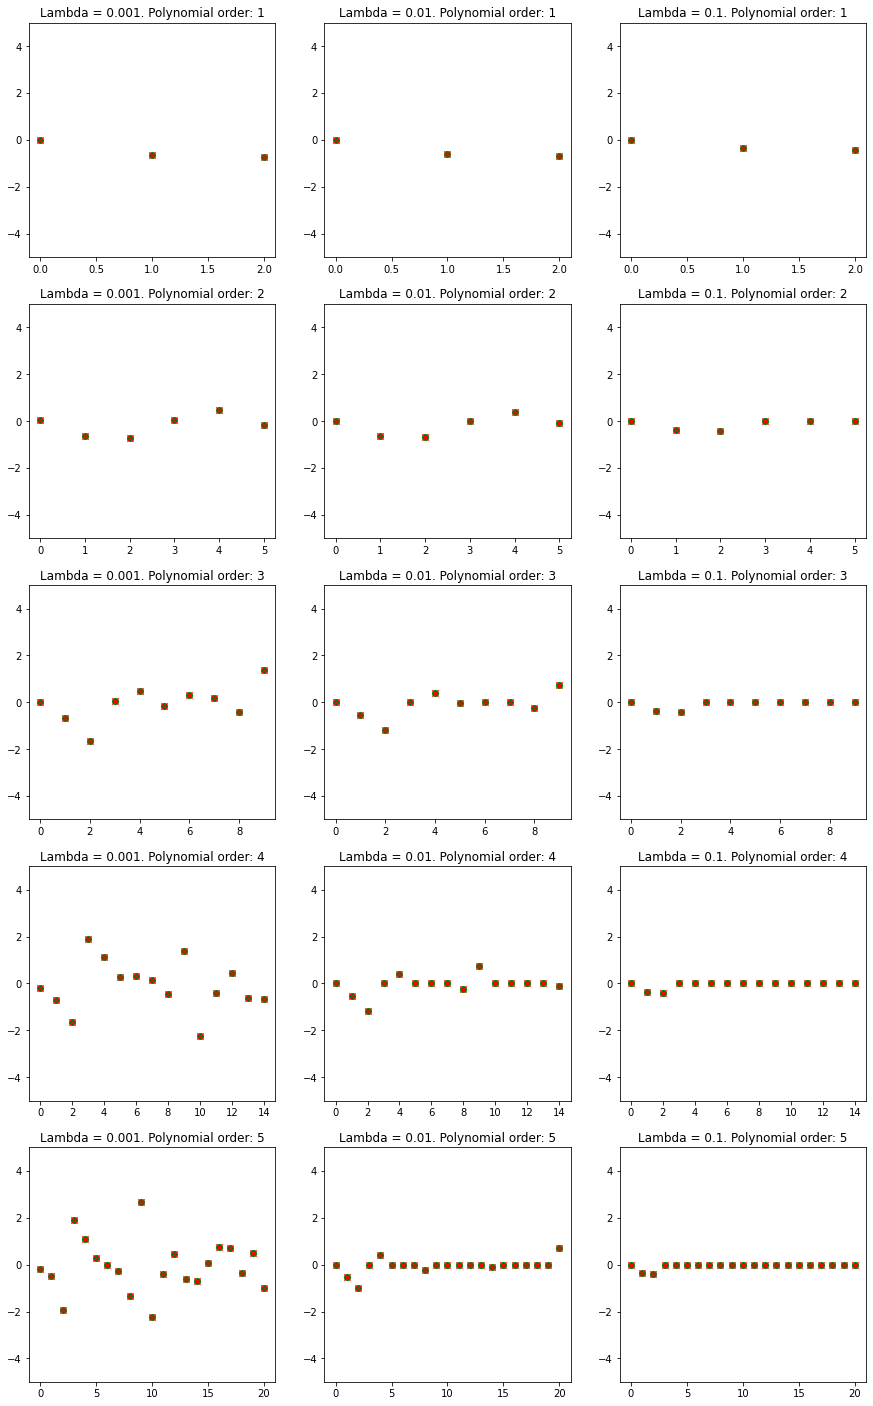

In [5]:
import matplotlib.pyplot as plt
n_polynom = 5 # plot polynoms up to n_polynom order
sigma = 2 # plot two sigma uncertainty
fig, axs = plt.subplots(n_polynom, 3, figsize=(15, 25), facecolor='w', edgecolor='k')

sigma = 1
for polynom_nr in range(n_polynom):
    for beta_nr_i in range((polynom_nr+2)**2): # extracts first beta values! 
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l1_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 0].plot(beta_nr_i, l1_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l1_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l2_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 1].plot(beta_nr_i, l2_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l2_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i], 'go') #plot middle beta
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i] - sigma*np.sqrt(
            l3_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx') 
        axs[polynom_nr, 2].plot(beta_nr_i, l3_mean_betas_bootstrap[polynom_nr][beta_nr_i] + sigma*np.sqrt(
            l3_var_betas_bootstrap[polynom_nr][beta_nr_i]), 'rx')   

    axs[polynom_nr, 0].set_title('Lambda = 0.001. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 0].set_ylim([-5, 5])
    axs[polynom_nr, 1].set_title('Lambda = 0.01. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 1].set_ylim([-5, 5])
    axs[polynom_nr, 2].set_title('Lambda = 0.1. Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr, 2].set_ylim([-5, 5])
plt.show()

Lasso is faster for larger values of lambda, thus I was not able to set lambda small enought to reconstruct any visible confidence intervals since setting lambda too low resulted in very long computational time. However we can see the same results here as in the Ridge analysis. The variance in beta values increases for larger polynomial orders. Increasing lambda drives beta values towards zero. Lasso also has the ability to cancel out beta values that are small enought (not important enought). 